<a href="https://colab.research.google.com/github/DSGP-Group-1-EAPS/SL-Apparel-Dataset/blob/Kavindu-Deshanjana/ARIMA_and_SARIMA_for_Sewing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [60]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import pickle

### Mounting the Drive

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Load preprocessed data from Excel file
file_path = '/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/preprocessed_data_new.xlsx'
data = pd.read_excel(file_path)


Mounted at /content/drive


In [4]:
print(data.columns)

Index(['Date', 'Shift', 'Code', 'Department', 'Absenteeism Type', 'Status',
       'Leave Type', 'Absent/Present', 'Reason', 'Joined Date', 'DaysWorked',
       'DayOfWeek', 'Encoded Code', 'LeaveMonth', 'Encoded Reason',
       'Encoded Status', 'Encoded Absenteeism Type', 'Encoded Shift',
       'LeaveYear', 'NumOfLeaveDays', 'TookLeaveNextMonth', 'LeavesNextMonth',
       'TargetCategory'],
      dtype='object')


### EDA

In [5]:
# Define a mapping of sub-departments to main departments
sub_dept_to_main_dept = {
    'Sewing Team': [sub_dept for sub_dept in data['Department'] if sub_dept.startswith('Sewing Team')]

}

# Map each sub-department to its main department
main_dept_for_sub_dept = {}
for main_dept, sub_depts in sub_dept_to_main_dept.items():
    for sub_dept in sub_depts:
        main_dept_for_sub_dept[sub_dept] = main_dept

# Add a new column indicating the main department for each row
data['MainDepartment'] = data['Department'].map(main_dept_for_sub_dept)

         Leave Type    DaysWorked     DayOfWeek  Encoded Code    LeaveMonth  \
count  40666.000000  40666.000000  40666.000000  40666.000000  40666.000000   
mean       1.000344   2403.587026      2.978901   1934.816431      6.658167   
std        0.018551   2279.222773      1.864973   1159.044997      3.533512   
min        1.000000     11.000000      1.000000      1.000000      1.000000   
25%        1.000000    490.000000      1.000000    899.000000      4.000000   
50%        1.000000   1635.000000      3.000000   1874.000000      6.000000   
75%        1.000000   3849.750000      4.000000   2937.000000     10.000000   
max        2.000000  10794.000000      7.000000   4298.000000     12.000000   

       Encoded Reason  Encoded Status  Encoded Absenteeism Type  \
count    40666.000000    40666.000000              40666.000000   
mean        12.149634        0.835981                  0.240373   
std          3.421216        0.370297                  0.427718   
min          0.00000

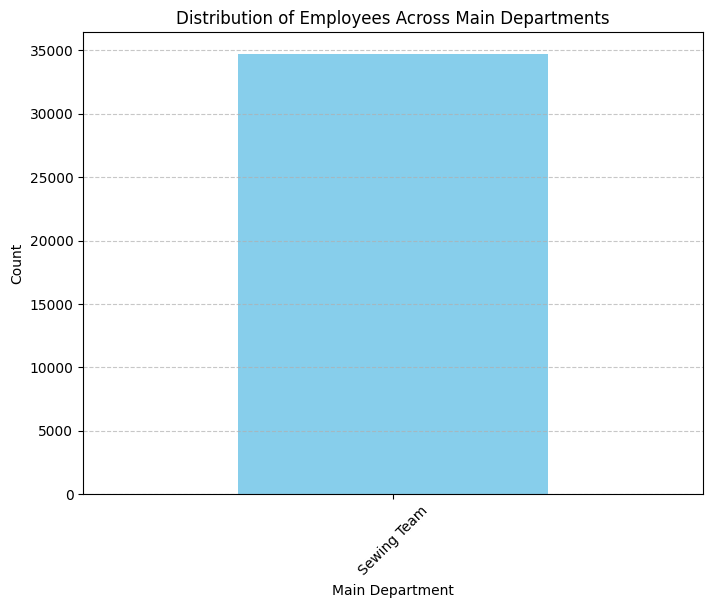

In [6]:
# Summary statistics
summary_stats = data.describe()
print(summary_stats)

# Distribution of Main Departments
main_dept_distribution = data['MainDepartment'].value_counts()
print(main_dept_distribution)

# Employee count by Sub-Departments
sub_dept_count = data['Department'].value_counts()
print(sub_dept_count)

# Plotting the distribution of main departments
plt.figure(figsize=(8, 6))
main_dept_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Employees Across Main Departments')
plt.xlabel('Main Department')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [7]:
# Summarize total absence by main department

# Filter data for Sewing Team
sewing_team_data = data[data['MainDepartment'] == 'Sewing Team']

total_absence_by_main_dept = data.groupby(['LeaveYear','LeaveMonth','MainDepartment']).size().reset_index(name='totalAbsence')
print(total_absence_by_main_dept)

    LeaveYear  LeaveMonth MainDepartment  totalAbsence
0        2021          12    Sewing Team          2870
1        2022           1    Sewing Team          1963
2        2022           2    Sewing Team          2064
3        2022           3    Sewing Team          2048
4        2022           4    Sewing Team          1543
5        2022           5    Sewing Team          2987
6        2022           6    Sewing Team          2544
7        2022           7    Sewing Team          1319
8        2022           8    Sewing Team          1489
9        2022           9    Sewing Team          1365
10       2022          10    Sewing Team          1659
11       2022          11    Sewing Team          1426
12       2022          12    Sewing Team           987
13       2023           1    Sewing Team           919
14       2023           2    Sewing Team           312
15       2023           3    Sewing Team          1032
16       2023           4    Sewing Team           433
17       2

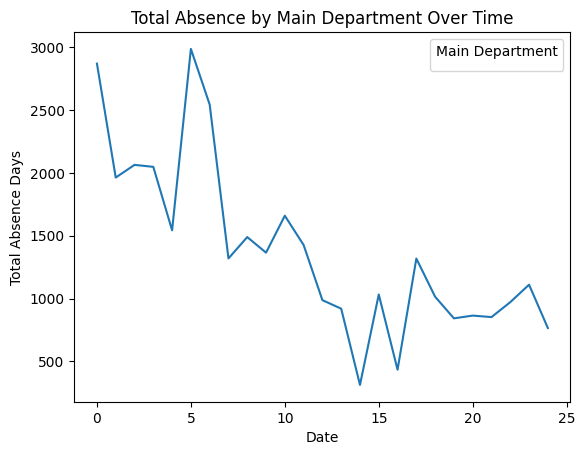

In [8]:
# Visualize the data
plt.plot(total_absence_by_main_dept['totalAbsence'])
plt.title('Total Absence by Main Department Over Time')
plt.xlabel('Date')
plt.ylabel('Total Absence Days')
plt.legend(title='Main Department')
plt.show()

### ADF Test

In [9]:
# Check for stationarity
def adf_test(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

### Splitting Data

In [10]:
# Train-test split
train_size = int(len(total_absence_by_main_dept['totalAbsence']) * 0.8)
train, test = total_absence_by_main_dept['totalAbsence'].iloc[:train_size], total_absence_by_main_dept['totalAbsence'].iloc[train_size:]

### ARIMA Model

In [11]:
# Fit ARIMA model for each main department
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit()

### Evaluating Model

                               SARIMAX Results                                
Dep. Variable:           totalAbsence   No. Observations:                   20
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -145.856
Date:                Mon, 11 Mar 2024   AIC                            301.712
Time:                        04:05:44   BIC                            306.434
Sample:                             0   HQIC                           302.511
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0469      0.396     -2.644      0.008      -1.823      -0.271
ar.L2         -0.2231      0.446     -0.500      0.617      -1.097       0.651
ma.L1          0.5440      0.748      0.727      0.4

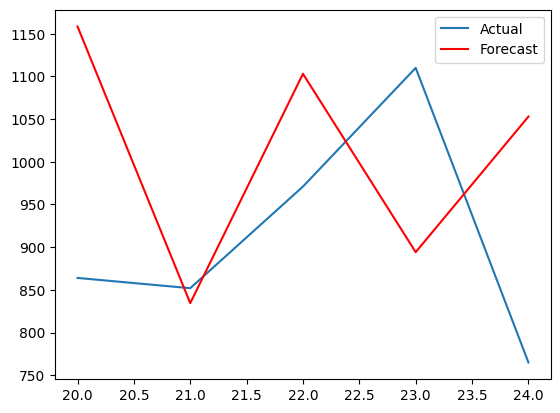

In [12]:
print(model_fit.summary())

forecast = model_fit.forecast(steps=len(test))
print(forecast)

mse = mean_squared_error(test, forecast)
print("MSE : ", mse)

rsme = np.sqrt(mse)
print("RSME : ", rsme)

plt.plot(test, label="Actual")
plt.plot(forecast, label="Forecast", color="red")
plt.legend()
plt.show()


### SARIMA Model
## ADF Test

In [13]:
# Check for stationarity
def adf_test(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


## Splitting Data

In [14]:
# Train-test split
train_size = int(len(total_absence_by_main_dept['totalAbsence']) * 0.9)
train, test = total_absence_by_main_dept['totalAbsence'].iloc[:train_size], total_absence_by_main_dept['totalAbsence'].iloc[train_size:]


## EDA

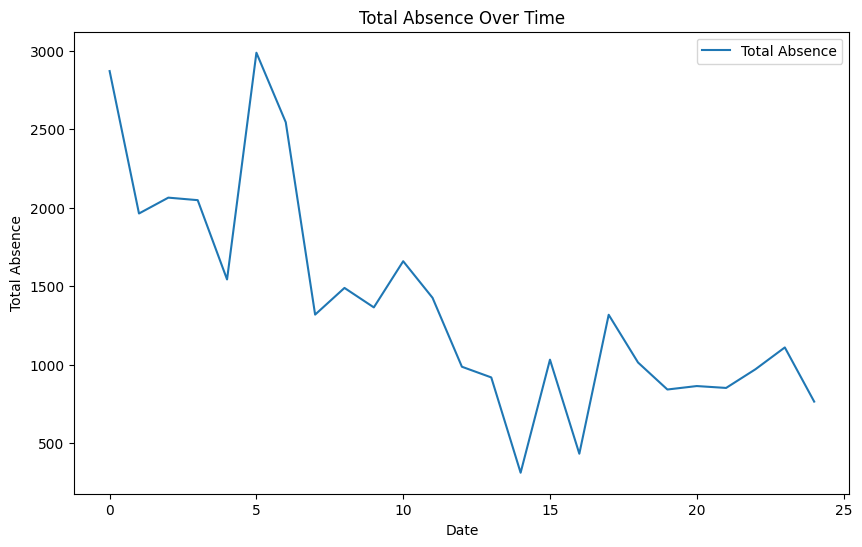

Descriptive Statistics:
count      25.000000
mean     1387.840000
std       696.671472
min       312.000000
25%       919.000000
50%      1318.000000
75%      1659.000000
max      2987.000000
Name: totalAbsence, dtype: float64


In [15]:
# EDA
# Data Visualization
plt.figure(figsize=(10, 6))
plt.plot(total_absence_by_main_dept['totalAbsence'], label='Total Absence')
plt.title('Total Absence Over Time')
plt.xlabel('Date')
plt.ylabel('Total Absence')
plt.legend()
plt.show()

# Descriptive Statistics
print("Descriptive Statistics:")
print(total_absence_by_main_dept['totalAbsence'].describe())

## SARIMA Model


In [58]:
# SARIMA modeling (continued from original code)
order = (3, 1, 2)  # Non-seasonal parameters
seasonal_order = (3, 1, 1, 4)  # Seasonal parameters, here assuming a yearly seasonal pattern

# Fit SARIMA model
model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# Forecast
forecast = model_fit.forecast(steps=len(test))
print(forecast)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


22    1005.357151
23    1111.169847
24     801.161732
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [62]:
# Save the model to a file
file_path = '/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/Models/Sewing_sarimax.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(model_fit, f)

### Evaluating the *Model*

MSE: 829.8177343137553
RMSE: 28.806557140931563


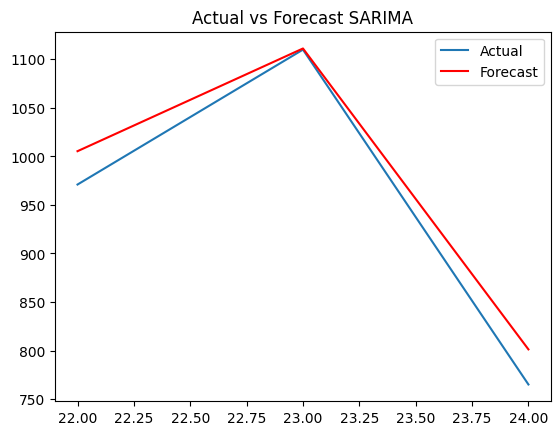

                                      SARIMAX Results                                      
Dep. Variable:                        totalAbsence   No. Observations:                   22
Model:             SARIMAX(3, 1, 2)x(3, 1, [1], 4)   Log Likelihood                -131.911
Date:                             Mon, 11 Mar 2024   AIC                            283.823
Time:                                     04:12:29   BIC                            292.155
Sample:                                          0   HQIC                           284.651
                                              - 22                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8586      0.960      0.894      0.371      -1.023       2.740
ar.L2         -0.3015      

In [59]:
# Calculate MSE and RMSE
mse = mean_squared_error(test, forecast)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# Visualize actual vs forecast
plt.plot(test, label="Actual")
plt.plot(forecast, label="Forecast", color="red")
plt.legend()
plt.title('Actual vs Forecast SARIMA')
plt.show()

print(model_fit.summary())